## Analysis of Spotify data

In this notebook, we are analysing the basic features of different Spotify songs. The goal being to cluster and them to define the metrics that can be used to recognize the type of a song as well as finding similar song. 

In [44]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import numpy as np

In [22]:
cid ="47e61e82d3044694b1735d8d566a159a" 
secret = "63c23dcc717745f389f658884059fc9c"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [23]:
start = timeit.default_timer()
artist_name, track_name, popularity, track_id = [], [], [], []

for i in range(0,10000,50):
    track_results = sp.search(q='year:2018', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
      
stop = timeit.default_timer()
print ('Time to run this code (in seconds):', stop - start)

Time to run this code (in seconds): 164.9163138461538


In [24]:
print('artist: ', len(artist_name))
print('\n track', len(track_name))
print('\n popularity', len(popularity))
print('\n track_id', len(track_id))

artist:  10000

 track 10000

 popularity 10000

 track_id 10000


In [25]:
dat = pd.DataFrame({'artist':artist_name,'track':track_name,'track_id':track_id,'popularity':popularity})

In [26]:
dat.head()

,artist,track,track_id,popularity
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,99
1,Los Unidades,E-Lo (feat. Jozzy),3eydp9rHJAskzOevEBK267,69
2,Post Malone,Wow.,6MWtB6iiXyIwun0YzU6DFP,98
3,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,95
4,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,98


In [27]:
dat.describe()

,popularity
count,10000.000000
mean,60.068500
std,8.547123
min,45.000000
25%,54.000000
50%,58.000000
75%,65.000000
max,99.000000


### Number of duplicate

In [28]:
grouped = dat.groupby(['artist','track'], as_index=True).size()
grouped[grouped > 1].count()

2218

In [29]:
dat.drop_duplicates(subset=['artist','track'], inplace=True)

In [30]:
dat.shape

(7102, 4)

In [31]:
start = timeit.default_timer()
rows = []
batchs = 100
# counter for None results
None_counter = 0

for i in range(0,len(dat['track_id']), batchs):
    batch = dat['track_id'][i:i+batchs]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:',None_counter)

stop = timeit.default_timer()
print ('Time to run this code (in seconds):',stop - start)

Number of tracks where no audio features were available: 1
Time to run this code (in seconds): 14.18450215384621


In [32]:
aud = pd.DataFrame.from_dict(rows,orient='columns')

In [33]:
aud.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.556,https://api.spotify.com/v1/audio-analysis/3KkX...,0.760,158040,0.479,3KkXRkHbMCARz0aVfEt68P,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,audio_features,spotify:track:3KkXRkHbMCARz0aVfEt68P,0.913
1,0.469,https://api.spotify.com/v1/audio-analysis/3eyd...,0.698,214720,0.797,3eydp9rHJAskzOevEBK267,0.001180,3,0.1520,-5.125,0,0.0615,101.969,4,https://api.spotify.com/v1/tracks/3eydp9rHJAsk...,audio_features,spotify:track:3eydp9rHJAskzOevEBK267,0.530
2,0.163,https://api.spotify.com/v1/audio-analysis/6MWt...,0.833,149520,0.539,6MWtB6iiXyIwun0YzU6DFP,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,audio_features,spotify:track:6MWtB6iiXyIwun0YzU6DFP,0.385
3,0.259,https://api.spotify.com/v1/audio-analysis/2IRZ...,0.889,180522,0.496,2IRZnDFmlqMuOrYOLnZZyc,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,https://api.spotify.com/v1/tracks/2IRZnDFmlqMu...,audio_features,spotify:track:2IRZnDFmlqMuOrYOLnZZyc,0.544
4,0.297,https://api.spotify.com/v1/audio-analysis/5p7u...,0.752,201661,0.488,5p7ujcrUXASCNwRaWNHR1C,0.000009,6,0.0936,-7.050,1,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533


In [34]:
aud.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,7101.000000,7101.000000,7.101000e+03,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000
mean,0.286346,0.643197,1.997923e+05,0.592851,0.100658,5.266582,0.174886,-7.677241,0.603014,0.123042,120.474384,3.927897,0.444939
std,0.300665,0.165805,5.605082e+04,0.218275,0.263634,3.629464,0.133836,4.483995,0.489308,0.120925,30.341934,0.392730,0.229429
min,0.000000,0.000000,3.082600e+04,0.000000,0.000000,0.000000,0.000000,-51.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038600,0.539000,1.704930e+05,0.462000,0.000000,2.000000,0.098400,-8.838000,0.000000,0.040400,95.036000,4.000000,0.263000
50%,0.162000,0.664000,1.984190e+05,0.617000,0.000002,5.000000,0.120000,-6.583000,1.000000,0.066900,120.012000,4.000000,0.433000
75%,0.465000,0.765000,2.262860e+05,0.755000,0.001170,8.000000,0.204000,-4.961000,1.000000,0.167000,142.218000,4.000000,0.616000
max,0.996000,0.985000,1.355938e+06,0.997000,0.997000,11.000000,0.981000,0.175000,1.000000,0.966000,220.099000,5.000000,0.981000


In [35]:
dat = dat.rename(columns={'track_id':'id'})

In [36]:
fdt = pd.merge(dat, aud, on='id', how='inner')

In [37]:
fdt.head()

,artist,track,id,popularity,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,99,0.556,https://api.spotify.com/v1/audio-analysis/3KkX...,0.760,158040,0.479,0.000000,...,0.0703,-5.574,1,0.0466,89.911,4,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,audio_features,spotify:track:3KkXRkHbMCARz0aVfEt68P,0.913
1,Los Unidades,E-Lo (feat. Jozzy),3eydp9rHJAskzOevEBK267,69,0.469,https://api.spotify.com/v1/audio-analysis/3eyd...,0.698,214720,0.797,0.001180,...,0.1520,-5.125,0,0.0615,101.969,4,https://api.spotify.com/v1/tracks/3eydp9rHJAsk...,audio_features,spotify:track:3eydp9rHJAskzOevEBK267,0.530
2,Post Malone,Wow.,6MWtB6iiXyIwun0YzU6DFP,98,0.163,https://api.spotify.com/v1/audio-analysis/6MWt...,0.833,149520,0.539,0.000002,...,0.1010,-7.399,0,0.1780,99.947,4,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,audio_features,spotify:track:6MWtB6iiXyIwun0YzU6DFP,0.385
3,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,95,0.259,https://api.spotify.com/v1/audio-analysis/2IRZ...,0.889,180522,0.496,0.000000,...,0.2520,-6.365,0,0.0905,86.003,4,https://api.spotify.com/v1/tracks/2IRZnDFmlqMu...,audio_features,spotify:track:2IRZnDFmlqMuOrYOLnZZyc,0.544
4,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,98,0.297,https://api.spotify.com/v1/audio-analysis/5p7u...,0.752,201661,0.488,0.000009,...,0.0936,-7.050,1,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533


In [38]:
fdt.shape

(7101, 21)

In [49]:
fdt.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,7101.000000,7101.000000,7101.000000,7.101000e+03,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000
mean,60.544994,0.286346,0.643197,1.997923e+05,0.592851,0.100658,5.266582,0.174886,-7.677241,0.603014,0.123042,120.474384,3.927897,0.444939
std,9.011252,0.300665,0.165805,5.605082e+04,0.218275,0.263634,3.629464,0.133836,4.483995,0.489308,0.120925,30.341934,0.392730,0.229429
min,45.000000,0.000000,0.000000,3.082600e+04,0.000000,0.000000,0.000000,0.000000,-51.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,0.038600,0.539000,1.704930e+05,0.462000,0.000000,2.000000,0.098400,-8.838000,0.000000,0.040400,95.036000,4.000000,0.263000
50%,59.000000,0.162000,0.664000,1.984190e+05,0.617000,0.000002,5.000000,0.120000,-6.583000,1.000000,0.066900,120.012000,4.000000,0.433000
75%,66.000000,0.465000,0.765000,2.262860e+05,0.755000,0.001170,8.000000,0.204000,-4.961000,1.000000,0.167000,142.218000,4.000000,0.616000
max,99.000000,0.996000,0.985000,1.355938e+06,0.997000,0.997000,11.000000,0.981000,0.175000,1.000000,0.966000,220.099000,5.000000,0.981000


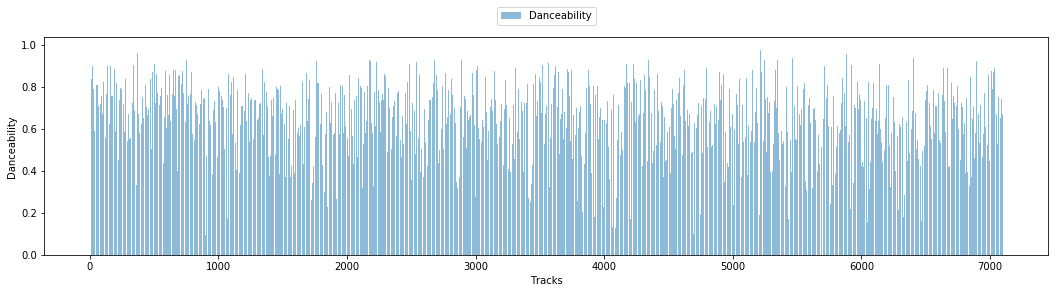

In [45]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(fdt.shape[0]), fdt['danceability'], alpha=0.5, label='Danceability')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Danceability')
plt.xlabel('Tracks')
plt.show()

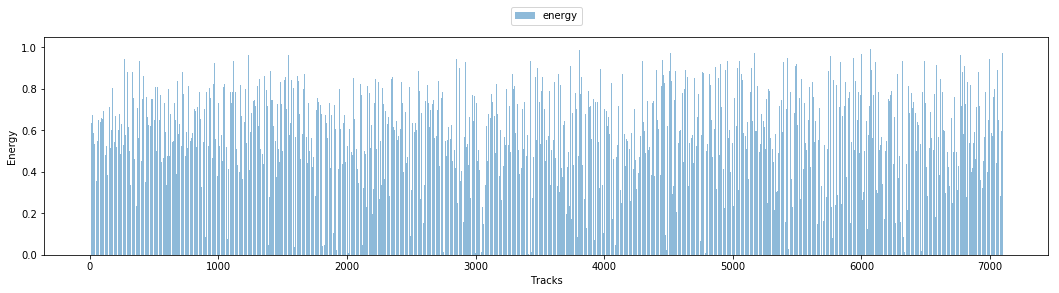

In [46]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(fdt.shape[0]), fdt['energy'], alpha=0.5, label='energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Tracks')
plt.show()

In [48]:
fdt.columns

Index(['artist', 'track', 'id', 'popularity', 'acousticness', 'analysis_url',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'type', 'uri', 'valence'],
      dtype='object')

In [50]:
fda = fdt[['popularity', 'acousticness', 'analysis_url',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence']]

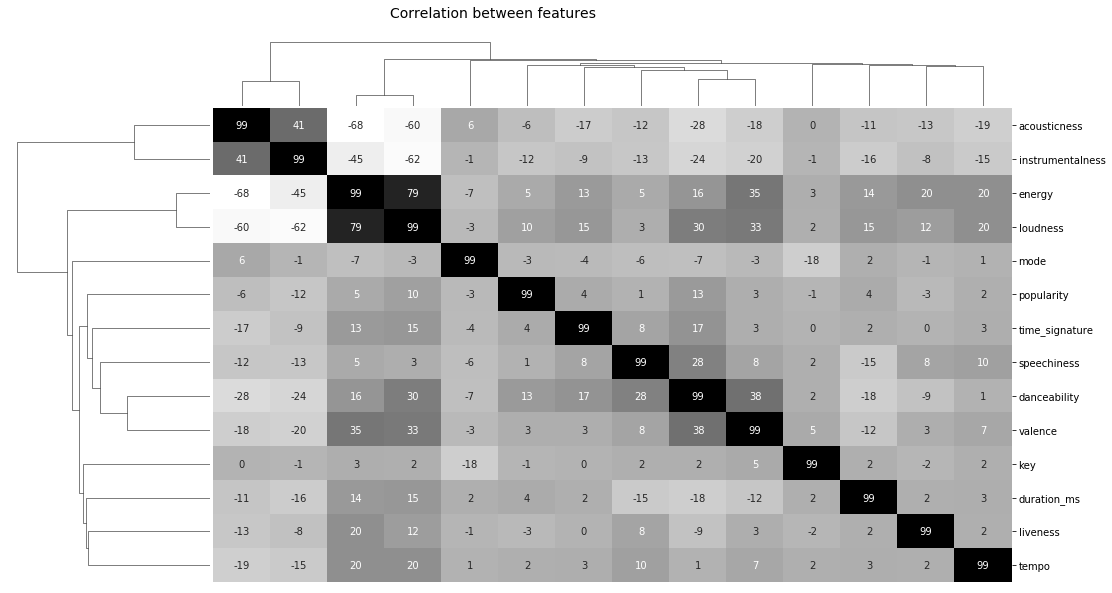

In [53]:
cor = fda.corr()
cor = pd.DataFrame(np.round(cor.values*100).astype('int').clip(max=99), columns=cor.columns, index=cor.index)
cmp = sns.clustermap(cor, cmap='Greys', annot=True, figsize=(18,10))
_ = cmp.fig.suptitle('Correlation between features', y=0.925, size=14) 
_ = cmp.cax.set_visible(False)
_ = cmp.ax_heatmap.set_xticks([])

From this visualization, we can see that two very different small clusters appear: {acousticness - instrumentalness} and {energy - loudness}